In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [8]:
# This path will be active after the launch of the hackathon
teamname = 'trachack-a-groups-admin-py-tracfone'
data_folder='s3://tf-trachack-data/212/'
# change root_folder to your team's root folder
# s3://tf-trachack-notebooks/<this should be replaced by team name as provided in EMAIL>/jupyter/jovyan/
root_folder='s3://tf-trachack-notebooks/trachack-project-groups-4-unavarra/jupyter/jovyan/'

In [9]:
def numerical_cleaner(df):
    
    df = df.select_dtypes(exclude=['datetime64','string','object'])

    skip_word = ["line_id","redemption_date","deactivation_date"]

    momentos_b1 = df.drop(columns=[col for col in df.columns if col in skip_word]).describe()

    # Hago transpuesta para poder utilizarlo como dataframe

    momentos_b1_T = momentos_b1.T

    # max_val =  momentos_b1_T["max"]
    # min_val = momentos_b1_T["min"]

    number_of_rows = momentos_b1_T.shape[0]

    index = momentos_b1_T.index

    # Creo las listas para encasillar las variables en estudio.

    variables_ruido = []
    
    # Para cada fila (variables columna que fueron puestas como filas) se analizara la columna max y min.
    # Para luego encasillar en las listas correspondientes.

    for i in range(0, number_of_rows):
        if momentos_b1_T["max"][i] == momentos_b1_T["min"][i]:
            variables_ruido.append(index[i])
        else:
            pass
        
    return sorted(set(variables_ruido))


def categorical_cleaner(df):
    
    df = df.select_dtypes(exclude=['float64','int64'])

    lista_columnas = []

    columnasdf = df.columns

    for i in range(len(columnasdf)):
        lista_columnas.append(columnasdf[i])

    index = df.index

    number_of_rows = len(index)

    # Calculo el porcentage de las 'entries' que son atribuidas a los diferentes valores en cada variable:

    variables_ruido = []
    
    lista_columnas.remove("line_id")

    for c in lista_columnas:

        if len(df[str(c)].value_counts()) == 0:

            variables_ruido.append(str(c))

        else:

            valores = (df[str(c)].value_counts() / number_of_rows) * 100
            # print(valores)

            for z in range(len(valores)):

                if valores[z] >= 95:

                    variables_ruido.append(str(c))

                else:
                    pass

    return variables_ruido


def total_creator(df,col1,col2):
    
    name_sep = str(col1.split('_')[0])
    
    name = name_sep + "_total"
    
    df[name] = abs(df[col1] - df[col2])
    
    return print("column_created")

def Other_label(df, col, n):
    # n is the number of biggest frequencies labels you want to keep
    
    biggest = df[col].value_counts().nlargest(n).index
    
    df[col] = np.where(df[col].isin(biggest), df[col], 'OTHER')
    
    return print("Done labeling with OTHER "+ str(col) + " column.")

def value_count_filter(df):
    
    col = df.columns.tolist()
    
    noise_list = []
    
    for i in col:
        
        if df[i].value_counts().nlargest(1)[0] > 6e6:
            
            noise_list.append(df[i].name)
            
        else:
            
            pass
    
    return noise_list

## 1. Upgrades

base dataset that has line_id, upgrade_date and upgrade columns.

### Variables

+ **line_id** = identificador único de número telefonico
+ **upgrade_date** = fecha del upgrade, si es que hay upgrade
+ **upgrade** = Target del estudio, realiza upgrade o no

In [10]:
upgrades=pd.read_csv(data_folder+"data/dev/upgrades.csv")
upgrades.head(2)

,line_id,date_observed,upgrade
0,f0b99d3b-32f7-4464-8fa8-87f27c9810a8,2021-03-14,yes
1,a2ec0baf-1720-4b1b-bfa3-db00ac8fcb00,2021-03-10,yes


In [11]:
upgrades["date_observed"] = pd.to_datetime(upgrades["date_observed"], format = '%Y-%m-%d')
upgrades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55868 entries, 0 to 55867
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   line_id        55868 non-null  object        
 1   date_observed  55868 non-null  datetime64[ns]
 2   upgrade        55868 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.3+ MB


## 2. Customer Info

customer info has carrier, plan and activation information for each line_id. One line_id in upgrades data has one and only record in customer info, hence you can do inner join on both.

+ **line_id** = identificador único de número telefonico
+ **carrier** = ni idea, pero es categorica y se divide en carrier 1, 2 y 3
+ **first_activation_date** = fecha de activación (de que? el número?)
+ **plan_name** = categórica, hay 4 planes o caen en Otro
+ **plan_subtype** = Smart o None, casi todos son None por lo que no aporta nada
+ **redemption_date** = Fecha de colección del pago? algo asi

In [12]:
customer_info = pd.read_csv(data_folder+"data/dev/customer_info.csv")
customer_info["first_activation_date"] = pd.to_datetime(customer_info["first_activation_date"], format = '%Y-%m-%d')
customer_info["redemption_date"] = pd.to_datetime(customer_info["redemption_date"], format = '%Y-%m-%d')
customer_info.drop('plan_subtype', axis='columns', inplace=True)

## 3. Phone Info

 phone info has all the device information for each line_id. One line_id in upgrades data has one and only record in phone info, hence inner join would be the right choice for both

In [13]:
# Read csv
phone_info=pd.read_csv(data_folder+"data/dev/phone_info.csv")

In [14]:
phone_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55868 entries, 0 to 55867
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   line_id                    55868 non-null  object 
 1   cpu_cores                  33740 non-null  object 
 2   expandable_storage         33241 non-null  float64
 3   gsma_device_type           44297 non-null  object 
 4   gsma_model_name            44297 non-null  object 
 5   gsma_operating_system      44297 non-null  object 
 6   internal_storage_capacity  33399 non-null  object 
 7   lte                        33831 non-null  float64
 8   lte_advanced               31224 non-null  float64
 9   lte_category               30927 non-null  float64
 10  manufacturer               33814 non-null  object 
 11  os_family                  33801 non-null  object 
 12  os_name                    33803 non-null  object 
 13  os_vendor                  33801 non-null  obj

In [15]:
# Exploratory analysis of model released year

lista_modelos_sinFecha = phone_info.loc[phone_info["year_released"].isna()]["gsma_model_name"].value_counts().index.tolist()

phone_info.loc[phone_info["year_released"].isna()]["gsma_model_name"].value_counts().nlargest(10)

XT2005DL     2311
LG L722DL     941
SM-S111DL     889
SM-S102DL     875
XT2052-DL     833
LG L455DL     771
SM-S215DL     648
LG L125DL     427
SM-S205DL     401
Z723EL        349
Name: gsma_model_name, dtype: int64

In [16]:
moto_list = [x for x in lista_modelos_sinFecha if x.startswith('XT')]

lg_list = [x for x in lista_modelos_sinFecha if x.startswith('LG')]

sm_list = [x for x in lista_modelos_sinFecha if x.startswith('SM')]

for i in (moto_list + lg_list + sm_list):
    
    print(i)

XT2005DL
XT2052-DL
XT2041DL
XT2041-4
XT2045-3
XT2043-4
XT1952-4
XT2013-4
XT2052-1
XT2019-2
XT2005-5
XT1962-6
XT2015-2
XT2041-1
XT2005-1PP
XT2027-1
XT1980-4
XT2010-1
XT2055-2
XT1955-6
XT1952-6
XT2005-1
XT2005-3
XT2041-6
XT2025-1
LG L722DL
LG L455DL
LG L125DL
LG L555DL
LG442BG
SM-S111DL
SM-S102DL
SM-S215DL
SM-S205DL
SM-S115DL
SM-S506DL
SM-G981U1
SM-A515F/DS
SM-A505U1
SM-A715F/DS
SM-G986U1
SM-G988U1
SM-A207M/DS
SM-A015A
SM-G986U
SM-A102U1
SM-A205U1
SM-A515U
SM-G985F/DS
SM-G981U
SM-A115M/DS
SM-A215U
SM-G988U
SM-A015M/DS
SM-G715U1
SM-A015T1
SM-G988B/DS


In [17]:
# For later imputation

def Updated_year_released(df, list_2019, list_2020, others):
    
    df["gsma_operating_system"] = np.where(df["gsma_operating_system"].isin(["Android","iOS"]),
                                                   df["gsma_operating_system"], 'Android')
    
    for i in range(len(df)):
        
        if pd.isna(df["gsma_operating_system"][i]):
            
            df.loc[i,"gsma_operating_system"] = "Android"
            
        else:
            
            pass
        
        if df["gsma_model_name"][i] in list_2019:
            
            df.loc[i,"year_released"] = 2019
            
        elif df["gsma_model_name"][i] in list_2020:
            
            df.loc[i,"year_released"] = 2020
            
        elif df["gsma_model_name"][i] in others:
            
            df.loc[i, "year_released"] = 2017
            
        else:
            
            pass
        
    return df

motorola_2019 = list(set(["XT2005-1","XT2005-3","XT2005DL","XT2029","XT2029-1","XT2025-2","XT1952-4",
                 "XT1952-6","XT2013","XT1955-6","XT1962-6","XT1980-4","XT2005-1PP",
                "XT2010-1","XT2013-4","XT2015-2","XT2019-2","XT2025-1"]))

motorola_2020 = list(set(["XT2053-2","XT2052-1", "XT2052-2", "XT2052-2PP", "XT2052-5", "XT2052-6", "XT2052-DL",
                "XT2041-4", "XT2041-6", "XT2041-7", "XT2041-DL","XT2045-3","XT2043","XT2043-4","XT2043-7",
                "XT2055-2","XT2027-1","XT2041-1","XT2041-4","XT2041-6","XT2041DL","XT2043-4","XT2045-3"]))

listed_2017 = ["LG442BG","SM-S115DL","Z723EL"]

lg_2019 = ["LG L722DL"]

lg_2020 = ["LG L455DL","LG L125DL","LG L555DL"]

sm_2019 = ["SM-A015M/DS","SM-A015T1","SM-S111DL","SM-A015A","SM-S506DL","SM-A102U1","SM-A205U1","SM-A207M/DS",
          "SM-A505U1","SM-A515F/DS","SM-A515U","SM-S102DL","SM-S205DL"]

sm_2020 = ["SM-G981U","SM-G981U1","SM-G985F/DS","SM-G986U","SM-G986U1","SM-G988B/DS","SM-G988U","SM-G988U1",
          "SM-G715U1","SM-A715F/DS","SM-A115M/DS","SM-A215U","SM-A715F/DS","SM-G715U1","SM-S215DL"]

model_2019 = motorola_2019 + lg_2019 + sm_2019

model_2020 = motorola_2020 + lg_2020 + sm_2020

# Matching models with their released year, which were searched in web pages.

phone_info = Updated_year_released(phone_info, model_2019, model_2020, listed_2017)

# Finald phone_info df

phone_info = phone_info[['line_id','gsma_operating_system','total_ram','touch_screen','wi_fi','year_released']]

replace_zero = ["touch_screen","wi_fi"]

for i in replace_zero:
    
    phone_info[i] = phone_info[i].fillna(0)
    
phone_info["year_released"] = phone_info["year_released"].astype(pd.Int64Dtype(), errors = "ignore").fillna(2018).astype(int)

phone_info[["wi_fi","touch_screen"]] = phone_info[["wi_fi","touch_screen"]].astype(pd.Int64Dtype(), errors = "ignore").astype(int)

phone_info.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55868 entries, 0 to 55867
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   line_id                55868 non-null  object
 1   gsma_operating_system  55868 non-null  object
 2   total_ram              33632 non-null  object
 3   touch_screen           55868 non-null  int64 
 4   wi_fi                  55868 non-null  int64 
 5   year_released          55868 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 2.6+ MB


In [18]:
# Merging 

df_1to3 = upgrades.merge(customer_info, on = 'line_id', how = 'inner')
df_1to3 = df_1to3.merge(phone_info, on = 'line_id', how = 'inner')

In [19]:
# Updating "upgrade" values.

df_1to3['upgrade'].replace({'yes':1,'no':0}, inplace=True)

In [20]:
df_1to3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55868 entries, 0 to 55867
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   line_id                55868 non-null  object        
 1   date_observed          55868 non-null  datetime64[ns]
 2   upgrade                55868 non-null  int64         
 3   carrier                55868 non-null  object        
 4   first_activation_date  55147 non-null  datetime64[ns]
 5   plan_name              42012 non-null  object        
 6   redemption_date        42012 non-null  datetime64[ns]
 7   gsma_operating_system  55868 non-null  object        
 8   total_ram              33632 non-null  object        
 9   touch_screen           55868 non-null  int64         
 10  wi_fi                  55868 non-null  int64         
 11  year_released          55868 non-null  int64         
dtypes: datetime64[ns](3), int64(4), object(5)
memory usage: 5.5+

In [21]:
df_prueba = df_1to3.loc[~df_1to3["plan_name"].isna()]

df_prueba.groupby(["total_ram","gsma_operating_system"])["upgrade"].mean()

total_ram        gsma_operating_system
1024             Android                  0.149171
                 iOS                      0.134769
1024/2048        Android                  0.000000
12288            Android                  0.558824
128              Android                  0.000000
1536             Android                  0.212632
1843             Android                  1.000000
2048             Android                  0.202938
                 iOS                      0.076022
2048/3072        Android                  0.333333
2048/4096        Android                  1.000000
256              Android                  0.368421
2560             Android                  0.300000
3072             Android                  0.308550
                 iOS                      0.212055
3072/4096        Android                  0.750000
3072/4096/6144   Android                  0.000000
32               Android                  0.500000
4                Android                  0

In [22]:
# Labeling categories

Other_label(df_1to3, "total_ram", 7)
Other_label(df_1to3, "plan_name", 3)

Done labeling with OTHER total_ram column.
Done labeling with OTHER plan_name column.


In [23]:
# Days from activation_date to observed_date (to give us an idea of how old the client is) 
# And redemption_date to observed_date (to give us an idea of how old the client current plan is)

df_1to3["activation_to_observed"] = (df_1to3["date_observed"] - df_1to3["first_activation_date"]).dt.days.astype(float, errors = 'ignore')
df_1to3["redemption_to_observed"] = (df_1to3["date_observed"] - df_1to3["redemption_date"]).dt.days.astype(float, errors = 'ignore')


In [24]:
# And (date_observed - year_released) to give us an idea of which clients tend to improve their model more often.

df_1to3["released_to_observed"] = (df_1to3["date_observed"].dt.year - df_1to3["year_released"]).astype(int, errors = 'ignore')


upgrade
0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
1    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

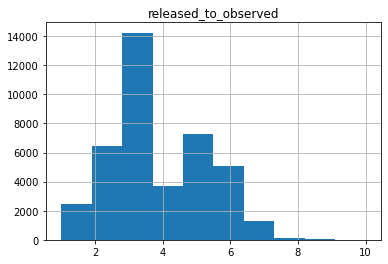

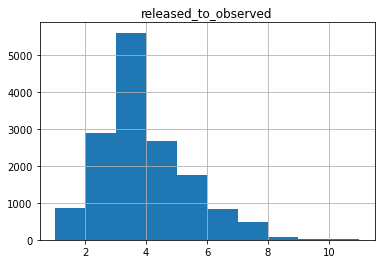

In [25]:
# Released to observed hist

df_1to3[["released_to_observed","upgrade"]].groupby("upgrade").hist()

<AxesSubplot:xlabel='upgrade', ylabel='released_to_observed'>

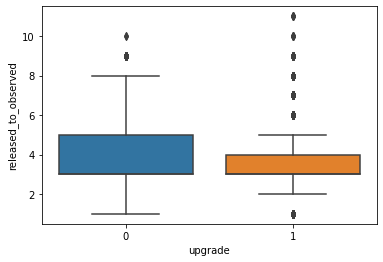

In [26]:
# Released to observed boxplot

sns.boxplot(x="upgrade", y="released_to_observed", data=df_1to3)

<AxesSubplot:xlabel='upgrade', ylabel='redemption_to_observed'>

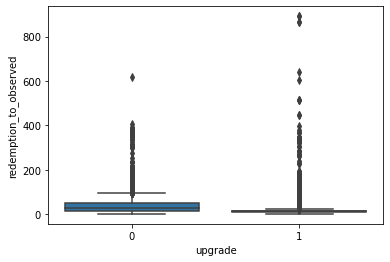

In [27]:
# Take it off as it doesn't represent clear differences

sns.boxplot(x="upgrade", y="redemption_to_observed", data=df_1to3)

<AxesSubplot:xlabel='upgrade', ylabel='activation_to_observed'>

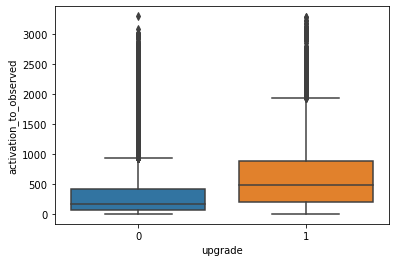

In [28]:
# Activation to observed boxplot

sns.boxplot(x="upgrade", y="activation_to_observed", data=df_1to3)

<AxesSubplot:xlabel='activation_to_observed', ylabel='Count'>

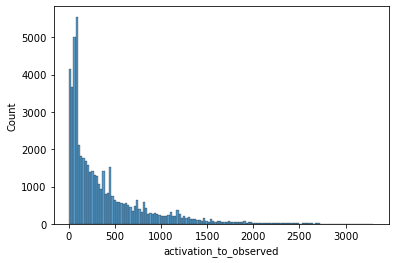

In [29]:
sns.histplot(x="activation_to_observed", data=df_1to3)

<AxesSubplot:xlabel='redemption_to_observed', ylabel='Count'>

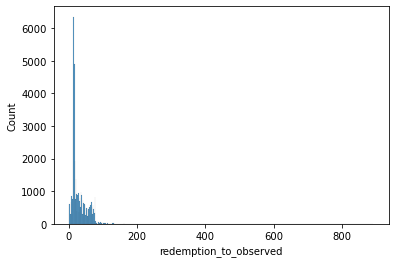

In [30]:
sns.histplot(x="redemption_to_observed", data=df_1to3)

upgrade
0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
1    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

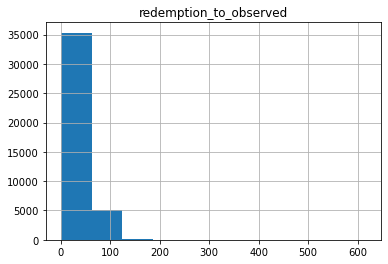

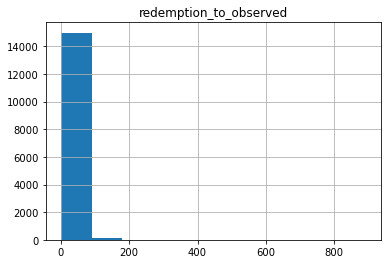

In [31]:
df_1to3["redemption_to_observed"] = df_1to3["redemption_to_observed"].fillna(df_1to3["redemption_to_observed"].median())

df_1to3[["redemption_to_observed","upgrade"]].groupby("upgrade").hist()

In [32]:
df_1to3.drop(["first_activation_date","redemption_date"], axis=1, inplace = True)
df_1to3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55868 entries, 0 to 55867
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   line_id                 55868 non-null  object        
 1   date_observed           55868 non-null  datetime64[ns]
 2   upgrade                 55868 non-null  int64         
 3   carrier                 55868 non-null  object        
 4   plan_name               55868 non-null  object        
 5   gsma_operating_system   55868 non-null  object        
 6   total_ram               55868 non-null  object        
 7   touch_screen            55868 non-null  int64         
 8   wi_fi                   55868 non-null  int64         
 9   year_released           55868 non-null  int64         
 10  activation_to_observed  55147 non-null  float64       
 11  redemption_to_observed  55868 non-null  float64       
 12  released_to_observed    55868 non-null  int64 

In [33]:
df_1to3["activation_to_observed"] = df_1to3["activation_to_observed"].fillna(df_1to3["activation_to_observed"].median()) 

In [34]:
df_1to3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55868 entries, 0 to 55867
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   line_id                 55868 non-null  object        
 1   date_observed           55868 non-null  datetime64[ns]
 2   upgrade                 55868 non-null  int64         
 3   carrier                 55868 non-null  object        
 4   plan_name               55868 non-null  object        
 5   gsma_operating_system   55868 non-null  object        
 6   total_ram               55868 non-null  object        
 7   touch_screen            55868 non-null  int64         
 8   wi_fi                   55868 non-null  int64         
 9   year_released           55868 non-null  int64         
 10  activation_to_observed  55868 non-null  float64       
 11  redemption_to_observed  55868 non-null  float64       
 12  released_to_observed    55868 non-null  int64 

In [35]:
prueba = df_1to3.copy()

In [36]:
prueba["plan_gsma"] = " "

for i in range(0,len(prueba.index.tolist())):
    
    prueba.loc[i,"plan_gsma"] = str(prueba["plan_name"][i])+"-"+str(prueba["gsma_operating_system"][i])

In [37]:
prueba["plan_gsma"].value_counts()

OTHER-Android     10863
plan 1-Android    10170
plan 2-Android     8138
plan 1-iOS         6597
plan 3-Android     5568
OTHER-iOS          5350
plan 2-iOS         5248
plan 3-iOS         3934
Name: plan_gsma, dtype: int64

In [38]:
prueba["total_ram"].value_counts()

OTHER    23168
2048     18966
3072      6236
4096      3401
1024      2140
6144       870
1536       637
512        450
Name: total_ram, dtype: int64

In [39]:
plan_gsma_means = prueba.groupby(["plan_gsma"])["upgrade"].mean()

prueba['plan_gsma'] = prueba['plan_gsma'].map(plan_gsma_means)

print(dict(plan_gsma_means))

{'OTHER-Android': 0.5365921016293842, 'OTHER-iOS': 0.5534579439252336, 'plan 1-Android': 0.09832841691248771, 'plan 1-iOS': 0.059572532969531605, 'plan 2-Android': 0.24096829687884, 'plan 2-iOS': 0.16577743902439024, 'plan 3-Android': 0.25287356321839083, 'plan 3-iOS': 0.19115404168784952}


In [40]:
ram_means = prueba.groupby(["total_ram"])["upgrade"].mean()

prueba['total_ram'] = prueba['total_ram'].map(ram_means)

print(dict(ram_means))

{'1024': 0.23551401869158878, '1536': 0.32339089481946626, '2048': 0.19302963197300432, '3072': 0.377325208466966, '4096': 0.6045280799764775, '512': 0.12444444444444444, '6144': 0.6758620689655173, 'OTHER': 0.2481871546961326}


In [41]:
carr_means = prueba.groupby(["carrier"])["upgrade"].mean()

prueba['carrier'] = prueba['carrier'].map(carr_means)

print(dict(carr_means))

{'carrier 1': 0.2958441406478538, 'carrier 2': 0.0014245014245014246, 'carrier 3': 0.00040241448692152917}


In [42]:
prueba.drop(["plan_name","gsma_operating_system"], axis = 1, inplace = True)

df_1to3 = prueba

df_1to3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55868 entries, 0 to 55867
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   line_id                 55868 non-null  object        
 1   date_observed           55868 non-null  datetime64[ns]
 2   upgrade                 55868 non-null  int64         
 3   carrier                 55868 non-null  float64       
 4   total_ram               55868 non-null  float64       
 5   touch_screen            55868 non-null  int64         
 6   wi_fi                   55868 non-null  int64         
 7   year_released           55868 non-null  int64         
 8   activation_to_observed  55868 non-null  float64       
 9   redemption_to_observed  55868 non-null  float64       
 10  released_to_observed    55868 non-null  int64         
 11  plan_gsma               55868 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(5), ob

In [43]:
from scipy import stats

lista_col = df_1to3.columns.tolist()

lista_col.remove('line_id')
lista_col.remove('date_observed')
lista_col.remove('upgrade')

for i in lista_col:

    a = df_1to3["upgrade"].to_numpy()

    b = df_1to3[i].to_numpy()
        
    print(stats.pointbiserialr(a, b), i)


PointbiserialrResult(correlation=0.18213042483247405, pvalue=0.0) carrier
PointbiserialrResult(correlation=0.2575033369419355, pvalue=0.0) total_ram
PointbiserialrResult(correlation=0.08594808845407895, pvalue=4.433779178957634e-92) touch_screen
PointbiserialrResult(correlation=0.0799325320055935, pvalue=7.367580791229313e-80) wi_fi
PointbiserialrResult(correlation=0.07522277819599466, pvalue=6.486691539270513e-71) year_released
PointbiserialrResult(correlation=0.30060727016257593, pvalue=0.0) activation_to_observed
PointbiserialrResult(correlation=-0.23961246091155713, pvalue=0.0) redemption_to_observed
PointbiserialrResult(correlation=-0.07522277819599442, pvalue=6.486691539270513e-71) released_to_observed
PointbiserialrResult(correlation=0.4128152501102317, pvalue=0.0) plan_gsma


# 4. Redemptions

In [44]:
# Reading of csv

redemptions=pd.read_csv(data_folder+"data/dev/redemptions.csv")

In [45]:
redemptions.drop(categorical_cleaner(redemptions), axis = 1, inplace = True)

In [46]:
#Agrupado por line_id para tener una fila por cliente
a = redemptions.groupby(['line_id']).nunique("line_id")
a = a["redemption_date"]

#Promedio de revenue generado por cliente
b = redemptions.groupby(["line_id"]).mean()

#Merge de ambos
redemptions = pd.merge(a, b, on = "line_id", how = "inner").reset_index()

#Df limpio
redemptions.columns = ["line_id", "redemption_count", "mean_revenue"]

# 5. Deactivations

In [47]:
# Reading of csv
deactivations=pd.read_csv(data_folder+"data/dev/deactivations.csv")

# Droping categorical noise

deactivations.drop(categorical_cleaner(deactivations), axis = 1, inplace = True)

In [48]:
# Featuring deactivations 

deactivations = deactivations.groupby("line_id").count().reset_index()
deactivations = deactivations[["line_id", "deactivation_date"]]
deactivations.columns = ["line_id", "deactivations_count"]
deactivations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44757 entries, 0 to 44756
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   line_id              44757 non-null  object
 1   deactivations_count  44757 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 699.5+ KB


# 6. Suspensions

In [49]:
# Cleaning and featuring

suspensions=pd.read_csv(data_folder+"data/dev/suspensions.csv")

suspensions = suspensions.astype({"suspension_start_date": 'datetime64[ns]', "suspension_end_date": 'datetime64[ns]'})

suspensions["days_suspended"] = (suspensions["suspension_end_date"] - 
                                 suspensions["suspension_start_date"]).dt.days.astype(float, errors = 'ignore').fillna(0)

suspensions["days_suspended"] = suspensions["days_suspended"].astype(int)

suspensions.drop(["suspension_start_date","suspension_end_date"], axis = "columns", inplace = True)

#Agrupado por line_id para tener una fila por cliente
z = suspensions.groupby(['line_id']).nunique("line_id")
z = z["days_suspended"]

#Promedio de revenue generado por cliente
y = suspensions.groupby(["line_id"]).mean()

#Merge de ambos
suspensions = pd.merge(z, y, on = "line_id", how = "inner").reset_index()

#Df limpio
suspensions.columns = ["line_id", "suspension_count", "mean_suspension_days"]

# 7. Network usage domestic

In [50]:
network_usage_domestic=pd.read_csv(data_folder+"data/dev/network_usage_domestic.csv")

network_usage_domestic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6381966 entries, 0 to 6381965
Data columns (total 13 columns):
 #   Column             Dtype  
---  ------             -----  
 0   line_id            object 
 1   date               object 
 2   hotspot_kb         float64
 3   kb_5g              float64
 4   mms_in             int64  
 5   mms_out            int64  
 6   sms_in             int64  
 7   sms_out            int64  
 8   total_kb           float64
 9   voice_count_in     int64  
 10  voice_count_total  int64  
 11  voice_min_in       int64  
 12  voice_min_out      int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 633.0+ MB


In [51]:
# Cleaning and featuring

network_usage_domestic["date"] = pd.to_datetime(network_usage_domestic["date"], format = '%Y-%m-%d')

for i in network_usage_domestic.columns.tolist():
    
    # creating bool series True for NaN values 
    bool_series = pd.isnull(network_usage_domestic[i]) 

    # filtering data
    print(network_usage_domestic[bool_series]) 

Empty DataFrame
Columns: [line_id, date, hotspot_kb, kb_5g, mms_in, mms_out, sms_in, sms_out, total_kb, voice_count_in, voice_count_total, voice_min_in, voice_min_out]
Index: []
Empty DataFrame
Columns: [line_id, date, hotspot_kb, kb_5g, mms_in, mms_out, sms_in, sms_out, total_kb, voice_count_in, voice_count_total, voice_min_in, voice_min_out]
Index: []
Empty DataFrame
Columns: [line_id, date, hotspot_kb, kb_5g, mms_in, mms_out, sms_in, sms_out, total_kb, voice_count_in, voice_count_total, voice_min_in, voice_min_out]
Index: []
Empty DataFrame
Columns: [line_id, date, hotspot_kb, kb_5g, mms_in, mms_out, sms_in, sms_out, total_kb, voice_count_in, voice_count_total, voice_min_in, voice_min_out]
Index: []
Empty DataFrame
Columns: [line_id, date, hotspot_kb, kb_5g, mms_in, mms_out, sms_in, sms_out, total_kb, voice_count_in, voice_count_total, voice_min_in, voice_min_out]
Index: []
Empty DataFrame
Columns: [line_id, date, hotspot_kb, kb_5g, mms_in, mms_out, sms_in, sms_out, total_kb, voice_

# 8. LRP Points


In [52]:
# Reading csv

lrp_points=pd.read_csv(data_folder+"data/dev/lrp_points.csv")

lrp_points.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8860 entries, 0 to 8859
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   line_id         8860 non-null   object 
 1   quantity        8859 non-null   float64
 2   status          8860 non-null   object 
 3   total_quantity  8859 non-null   float64
 4   update_date     8860 non-null   object 
dtypes: float64(2), object(3)
memory usage: 346.2+ KB


In [53]:
# Cleaning

lrp_points["update_date"] = pd.to_datetime(lrp_points["update_date"], format = '%Y-%m-%d')

# creating bool series True for NaN values 
bool_series = pd.isnull(lrp_points["quantity"]) 
    
# filtering data
lrp_points[bool_series] 


,line_id,quantity,status,total_quantity,update_date
1029,6b14e3db-483f-44ea-ab28-80f1473576c4,NaN,ENROLLED,NaN,2021-01-25


In [54]:
values = {'quantity': 0, 'total_quantity': 0}

lrp_points = lrp_points.fillna(value=values)

lrp_points.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8860 entries, 0 to 8859
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   line_id         8860 non-null   object        
 1   quantity        8860 non-null   float64       
 2   status          8860 non-null   object        
 3   total_quantity  8860 non-null   float64       
 4   update_date     8860 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 346.2+ KB


# 9. LRP Enrollment

In [55]:
lrp_enrollment=pd.read_csv(data_folder+"data/dev/lrp_enrollment.csv")

lrp_enrollment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17634 entries, 0 to 17633
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   line_id              17634 non-null  object
 1   lrp_enrolled         17634 non-null  object
 2   lrp_enrollment_date  17634 non-null  object
dtypes: object(3)
memory usage: 413.4+ KB


In [56]:
lrp_enrollment["lrp_enrollment_date"] = pd.to_datetime(lrp_enrollment["lrp_enrollment_date"], format = '%Y-%m-%d')

In [57]:
lrp_enrollment['lrp_enrolled'].replace({'Y':1}, inplace=True)

In [58]:
# network_usage_domestic noise

net_numeric = numerical_cleaner(network_usage_domestic)

# lrp_points noise

lrp_pNumeric = numerical_cleaner(lrp_points)

lrp_pCat = categorical_cleaner(lrp_points)

# lrp_enrollment noise

lrp_enCat = categorical_cleaner(lrp_enrollment)

In [59]:
def flattenList(nested_list):
    results = []
    for i in nested_list:
        if isinstance(i, list):
            results.extend(i)
            results = flattenList(results)
        else:
            results.append(i)
    return results

noise = flattenList(net_numeric + lrp_pNumeric + lrp_pCat + lrp_enCat)

noise

['status']

In [60]:
count_noise = value_count_filter(network_usage_domestic)

network_usage_domestic.drop(count_noise, axis='columns', inplace=True)

network_usage_mean = network_usage_domestic.groupby("line_id").mean().reset_index()

# Creating totals

total_creator(network_usage_mean,"voice_min_in","voice_min_out")
total_creator(network_usage_mean,"sms_in","sms_out")
total_creator(network_usage_mean,"mms_in","mms_out")

# Droping previous columns no longer necessary

network_usage_mean.drop(["voice_min_in","voice_min_out","voice_count_in","mms_in","mms_out","sms_in","sms_out"], axis='columns', inplace=True)

# Final df

network_usage_domestic = network_usage_mean[["line_id","voice_count_total","sms_total","total_kb"]]


column_created
column_created
column_created


In [61]:
df_7to9 = pd.merge(network_usage_domestic, lrp_points[["line_id","total_quantity"]], on = "line_id", how = 'left')

df_7to9 = pd.merge(df_7to9, lrp_enrollment[["line_id","lrp_enrolled"]], on = "line_id", how = 'left')

df_7to9["lrp_enrolled"] = df_7to9["lrp_enrolled"].fillna(0)  

In [62]:
df_7to9["total_quantity"] = df_7to9["total_quantity"].fillna(0)

In [63]:
df_7to9.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55126 entries, 0 to 55125
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   line_id            55126 non-null  object 
 1   voice_count_total  55126 non-null  float64
 2   sms_total          55126 non-null  float64
 3   total_kb           55126 non-null  float64
 4   total_quantity     55126 non-null  float64
 5   lrp_enrolled       55126 non-null  float64
dtypes: float64(5), object(1)
memory usage: 2.9+ MB


# JOINS

In [286]:
df = pd.merge(df_1to3, redemptions, on = "line_id", how = "left")

df = pd.merge(df, deactivations, on = "line_id", how = "left")

df = pd.merge(df, suspensions, on = "line_id", how = "left")

df = pd.merge(df, df_7to9, on = "line_id", how = "left")

df = df.drop_duplicates(subset=['line_id'])

#df.drop("date_observed", axis = 1, inplace = True)

#df.drop("mean_revenue", axis = 1, inplace = True)

df.drop("year_released", axis = 1, inplace = True)

#df.drop("wi_fi", axis = 1, inplace = True)

df.drop("line_id", axis = 1, inplace = True)

#df.drop("total_ram", axis = 1, inplace = True)

#df.drop("carrier", axis = 1, inplace = True)

#df.drop("sms_total", axis = 1, inplace = True)

#df.drop("touch_screen", axis = 1, inplace = True)

In [287]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55868 entries, 0 to 55875
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date_observed           55868 non-null  datetime64[ns]
 1   upgrade                 55868 non-null  int64         
 2   carrier                 55868 non-null  float64       
 3   total_ram               55868 non-null  float64       
 4   touch_screen            55868 non-null  int64         
 5   wi_fi                   55868 non-null  int64         
 6   activation_to_observed  55868 non-null  float64       
 7   redemption_to_observed  55868 non-null  float64       
 8   released_to_observed    55868 non-null  int64         
 9   plan_gsma               55868 non-null  float64       
 10  redemption_count        54885 non-null  float64       
 11  mean_revenue            54885 non-null  float64       
 12  deactivations_count     44757 non-null  float6

In [288]:
X = df

X["lrp_enrolled"] = X["lrp_enrolled"].fillna(0)

X["total_quantity"] = X["total_quantity"].fillna(0)

X["sms_total"] = X["sms_total"].fillna(X["sms_total"].median())

X["total_kb"] = X["total_kb"].fillna(X["total_kb"].median())

X["voice_count_total"] = X["voice_count_total"].fillna(X["voice_count_total"].median())

X["redemption_count"] = X["redemption_count"].fillna(X["redemption_count"].median())


X["deactivations_count"] = X["deactivations_count"].fillna(X["deactivations_count"].median())


X["suspension_count"] = X["suspension_count"].fillna(X["suspension_count"].median())

X.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 55868 entries, 0 to 55875
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date_observed           55868 non-null  datetime64[ns]
 1   upgrade                 55868 non-null  int64         
 2   carrier                 55868 non-null  float64       
 3   total_ram               55868 non-null  float64       
 4   touch_screen            55868 non-null  int64         
 5   wi_fi                   55868 non-null  int64         
 6   activation_to_observed  55868 non-null  float64       
 7   redemption_to_observed  55868 non-null  float64       
 8   released_to_observed    55868 non-null  int64         
 9   plan_gsma               55868 non-null  float64       
 10  redemption_count        55868 non-null  float64       
 11  mean_revenue            54885 non-null  float64       
 12  deactivations_count     55868 non-null  float6

In [289]:
df_dropna = X.dropna()

df_dropna.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48333 entries, 0 to 55875
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date_observed           48333 non-null  datetime64[ns]
 1   upgrade                 48333 non-null  int64         
 2   carrier                 48333 non-null  float64       
 3   total_ram               48333 non-null  float64       
 4   touch_screen            48333 non-null  int64         
 5   wi_fi                   48333 non-null  int64         
 6   activation_to_observed  48333 non-null  float64       
 7   redemption_to_observed  48333 non-null  float64       
 8   released_to_observed    48333 non-null  int64         
 9   plan_gsma               48333 non-null  float64       
 10  redemption_count        48333 non-null  float64       
 11  mean_revenue            48333 non-null  float64       
 12  deactivations_count     48333 non-null  float6

In [290]:
df_dropna.drop(["deactivations_count","date_observed","wi_fi","released_to_observed","redemption_count"], axis = 1, inplace = True)

df_dropna.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48333 entries, 0 to 55875
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   upgrade                 48333 non-null  int64  
 1   carrier                 48333 non-null  float64
 2   total_ram               48333 non-null  float64
 3   touch_screen            48333 non-null  int64  
 4   activation_to_observed  48333 non-null  float64
 5   redemption_to_observed  48333 non-null  float64
 6   plan_gsma               48333 non-null  float64
 7   mean_revenue            48333 non-null  float64
 8   suspension_count        48333 non-null  float64
 9   mean_suspension_days    48333 non-null  float64
 10  voice_count_total       48333 non-null  float64
 11  sms_total               48333 non-null  float64
 12  total_kb                48333 non-null  float64
 13  total_quantity          48333 non-null  float64
 14  lrp_enrolled            48333 non-null

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [291]:
from scipy import stats

def point_biserial(df):

    lista_col = df.columns.tolist()

    # remuevo columnas a las que no quisiera aplicar la correlacion
    #lista_col.remove('date_observed')
    lista_col.remove('upgrade')

    for i in lista_col:

        a = df["upgrade"].to_numpy()

        b = df[i].to_numpy()
        
        print(stats.pointbiserialr(a, b), i)
        
    return print("PointBiserial Results for your dataframe")

point_biserial(df_dropna)

PointbiserialrResult(correlation=0.1822531026110119, pvalue=0.0) carrier
PointbiserialrResult(correlation=0.2511697574587066, pvalue=0.0) total_ram
PointbiserialrResult(correlation=0.0659285875702987, pvalue=1.0524289112198819e-47) touch_screen
PointbiserialrResult(correlation=0.2949364209892084, pvalue=0.0) activation_to_observed
PointbiserialrResult(correlation=-0.24116056590615742, pvalue=0.0) redemption_to_observed
PointbiserialrResult(correlation=0.4015749857016053, pvalue=0.0) plan_gsma
PointbiserialrResult(correlation=0.10939571862251724, pvalue=1.4624070208091084e-128) mean_revenue
PointbiserialrResult(correlation=-0.03839540610197914, pvalue=3.0656512714464836e-17) suspension_count
PointbiserialrResult(correlation=-0.3023405319191462, pvalue=0.0) mean_suspension_days
PointbiserialrResult(correlation=0.1626956581703203, pvalue=6.388490079002423e-284) voice_count_total
PointbiserialrResult(correlation=0.13923632742920705, pvalue=9.00775280275786e-208) sms_total
PointbiserialrRes

In [292]:
# deactivations count, dice no tener relacion con p value > 0.05

In [293]:
# X will carry out the variables and y will be the target

y = df_dropna["upgrade"].copy()

X = df_dropna.drop("upgrade", axis = 1)

In [294]:
X.head()

,carrier,total_ram,touch_screen,activation_to_observed,redemption_to_observed,plan_gsma,mean_revenue,suspension_count,mean_suspension_days,voice_count_total,sms_total,total_kb,total_quantity,lrp_enrolled
0,0.295844,0.323391,1,951.0,20.0,0.536592,44.225806,3.0,12.000000,0.222222,0.627778,2.871749e+05,0.0,1.0
1,0.295844,0.377325,1,699.0,20.0,0.553458,50.728800,1.0,1.000000,3.461111,0.233333,5.256640e+05,0.0,1.0
2,0.295844,0.193030,1,175.0,20.0,0.553458,35.000000,4.0,11.666667,1.763314,0.301775,1.990593e+05,0.0,0.0
4,0.295844,0.675862,1,191.0,20.0,0.536592,54.000000,2.0,1.125000,6.061111,2.900000,1.023210e+06,0.0,0.0
5,0.000402,0.248187,0,65.0,25.0,0.098328,20.000000,2.0,13.428571,15.615385,1.200000,3.190443e+05,0.0,0.0


In [295]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48333 entries, 0 to 55875
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   carrier                 48333 non-null  float64
 1   total_ram               48333 non-null  float64
 2   touch_screen            48333 non-null  int64  
 3   activation_to_observed  48333 non-null  float64
 4   redemption_to_observed  48333 non-null  float64
 5   plan_gsma               48333 non-null  float64
 6   mean_revenue            48333 non-null  float64
 7   suspension_count        48333 non-null  float64
 8   mean_suspension_days    48333 non-null  float64
 9   voice_count_total       48333 non-null  float64
 10  sms_total               48333 non-null  float64
 11  total_kb                48333 non-null  float64
 12  total_quantity          48333 non-null  float64
 13  lrp_enrolled            48333 non-null  float64
dtypes: float64(13), int64(1)
memory usage:

In [282]:
def summary_PCA(df):

    scaler = StandardScaler()
    scaler.fit(df)
    df_scaled = scaler.transform(df)

    pca = PCA()

    pca.fit(df_scaled)

    pca_data = pca.transform(df_scaled)
    
    plt.figure(figsize=(20,10))
    
    print(np.round(pca.explained_variance_ratio_ * 100, decimals=1))

    per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
    labels = ['PC' +str(x) for x in range(1, len(per_var)+1)]
    plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label = labels)
    plt.ylabel('Percentage of explained variance')
    plt.xlabel('Principal Component')
    plt.title('Scree Plot')
    plt.show()
    
    def biplot(Z, components, pca_index_1, pca_index_2, labels, target):
        
        xc = Z[:, pca_index_1]
        yc = Z[:, pca_index_2]
        n = Z.shape[1]

        indices = [pca_index_1, pca_index_2]
        coeff = components[indices].T
        
        plt.figure(figsize=(20,10))

        plt.scatter(xc, yc, target, alpha=0.5)

        for i in range(n):
            plt.arrow(0, 0, coeff[i, 0] * 2, coeff[i, 1] * 2, color='r', width=0.02, head_width=0.1)
            plt.text(coeff[i,0] * 2.5, coeff[i,1] * 2.5, labels[i], color='k', ha='center', va='center')    

        plt.xlim(-4, 4)
        plt.ylim(-3, 3)
        plt.xlabel("PC{}".format(pca_index_1+1))
        plt.ylabel("PC{}".format(pca_index_2+1))
        plt.grid()
        
    biplot(pca_data, pca.components_, 0, 1, labels, y)
        
    return print("Done PCA")

[22.1 16.  14.3 12.6 10.3  9.9  7.7  7.2]


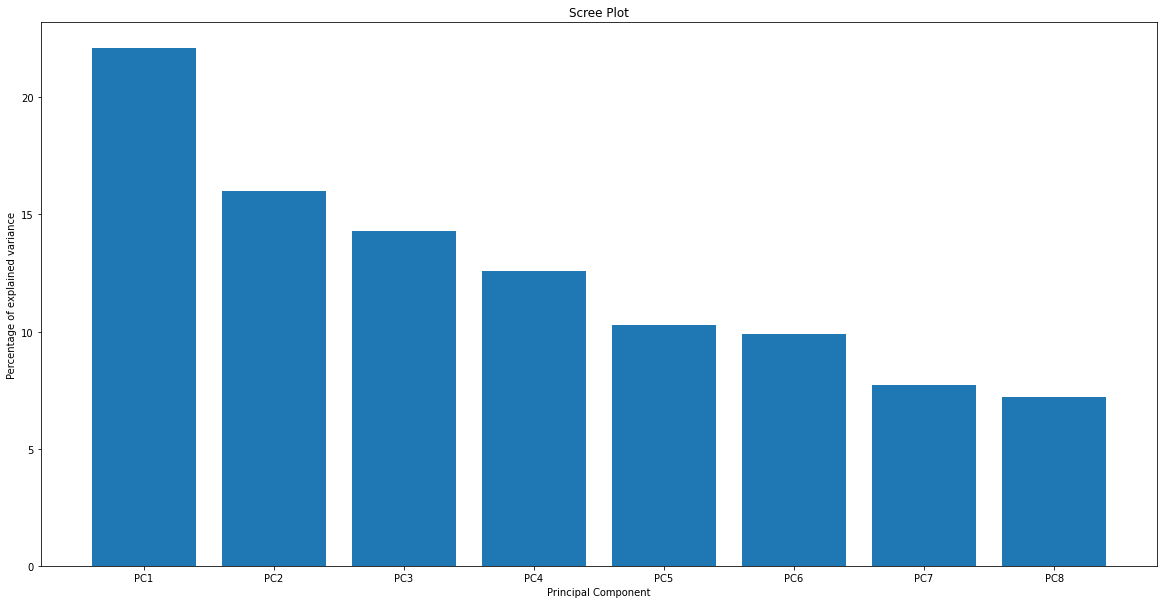

Done PCA


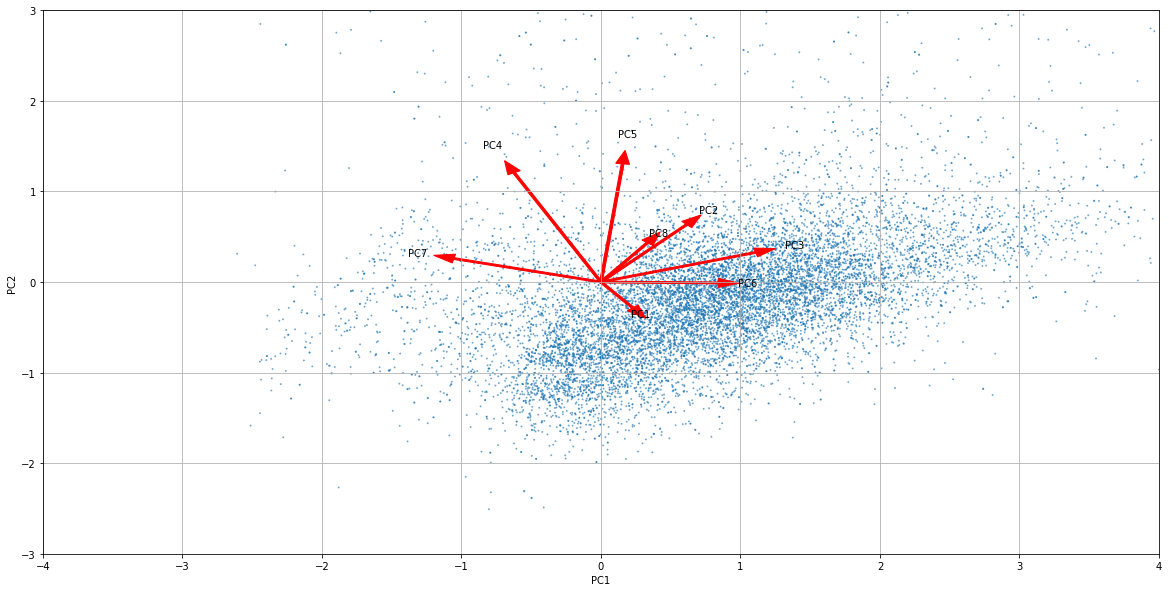

In [283]:
summary_PCA(X)

In [86]:
def pca_to_SVM(X, y, n):

    scaler = StandardScaler()

    scaler.fit(X)

    X_scaled = scaler.transform(X)

    pca = PCA(n_components = n)

    pca.fit(X_scaled)

    pca_X = pca.transform(X_scaled)

    return model_SVM(pca_X, y)

In [125]:
# SVM

def model_SVM(X, y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.80, random_state = 12)

    scaler = StandardScaler()

    scaler.fit(X_train)

    scaler.fit(X_test)

    X_train_scaled = scaler.transform(X_train)

    X_test_scaled = scaler.transform(X_test)

    print(X_train_scaled.shape)

    print(X_test_scaled.shape)
    
    trac_SVM = SVC(C = 100, gamma = 'scale', kernel = 'rbf',random_state = 12)

    trac_SVM.fit(X_train_scaled, y_train)
    
    plot_confusion_matrix(trac_SVM,
                     X_test_scaled,
                     y_test,
                     display_labels = ["Did not upgrade","Upgraded"])
    
    y_pred=trac_SVM.predict(X_test_scaled)
    
    f1 = f1_score(y_test, y_pred)
    
    return print("Your f1 score is {}".format(f1))
    

(38666, 8)
(9667, 8)
Your f1 score is 0.6983479502345502


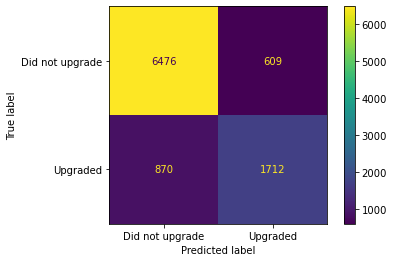

In [285]:
model_SVM(X, y)

In [ ]:
#SVM CV

def model_SVM_CV(X, y):
    
    scaler = StandardScaler()
    
    scaler.fit(X)
    
    X_scaled = scaler.transform(X)
    
    trac_SVM = SVC(C = 100, gamma = 'scale', kernel = 'rbf',random_state = 12)
    
    scores = cross_val_score(trac_SVM, X_scaled, y, cv=5, scoring='f1')
    
    max_value = np.max(scores)
    
    return print("Your max f1 score is {}".format(max_value))
    

# EVAL

In [296]:
upgrades=pd.read_csv(data_folder+"data/eval/upgrades.csv")

upgrades["date_observed"] = pd.to_datetime(upgrades["date_observed"], format = '%Y-%m-%d')

customer_info = pd.read_csv(data_folder+"data/eval/customer_info.csv")
customer_info["first_activation_date"] = pd.to_datetime(customer_info["first_activation_date"], format = '%Y-%m-%d')
customer_info["redemption_date"] = pd.to_datetime(customer_info["redemption_date"], format = '%Y-%m-%d')
customer_info.drop('plan_subtype', axis='columns', inplace=True)

phone_info=pd.read_csv(data_folder+"data/eval/phone_info.csv")

# For later imputation

def Updated_year_released(df, list_2019, list_2020, others):
    
    df["gsma_operating_system"] = np.where(df["gsma_operating_system"].isin(["Android","iOS"]),
                                                   df["gsma_operating_system"], 'Android')
    
    for i in range(len(df)):
        
        if pd.isna(df["gsma_operating_system"][i]):
            
            df.loc[i,"gsma_operating_system"] = "Android"
            
        else:
            
            pass
        
        if df["gsma_model_name"][i] in list_2019:
            
            df.loc[i,"year_released"] = 2019
            
        elif df["gsma_model_name"][i] in list_2020:
            
            df.loc[i,"year_released"] = 2020
            
        elif df["gsma_model_name"][i] in others:
            
            df.loc[i, "year_released"] = 2017
            
        else:
            
            pass
        
    return df

motorola_2019 = list(set(["XT2005-1","XT2005-3","XT2005DL","XT2029","XT2029-1","XT2025-2","XT1952-4",
                 "XT1952-6","XT2013","XT1955-6","XT1962-6","XT1980-4","XT2005-1PP",
                "XT2010-1","XT2013-4","XT2015-2","XT2019-2","XT2025-1"]))

motorola_2020 = list(set(["XT2053-2","XT2052-1", "XT2052-2", "XT2052-2PP", "XT2052-5", "XT2052-6", "XT2052-DL",
                "XT2041-4", "XT2041-6", "XT2041-7", "XT2041-DL","XT2045-3","XT2043","XT2043-4","XT2043-7",
                "XT2055-2","XT2027-1","XT2041-1","XT2041-4","XT2041-6","XT2041DL","XT2043-4","XT2045-3"]))

listed_2017 = ["LG442BG","SM-S115DL","Z723EL"]

lg_2019 = ["LG L722DL"]

lg_2020 = ["LG L455DL","LG L125DL","LG L555DL"]

sm_2019 = ["SM-A015M/DS","SM-A015T1","SM-S111DL","SM-A015A","SM-S506DL","SM-A102U1","SM-A205U1","SM-A207M/DS",
          "SM-A505U1","SM-A515F/DS","SM-A515U","SM-S102DL","SM-S205DL"]

sm_2020 = ["SM-G981U","SM-G981U1","SM-G985F/DS","SM-G986U","SM-G986U1","SM-G988B/DS","SM-G988U","SM-G988U1",
          "SM-G715U1","SM-A715F/DS","SM-A115M/DS","SM-A215U","SM-A715F/DS","SM-G715U1","SM-S215DL"]

model_2019 = motorola_2019 + lg_2019 + sm_2019

model_2020 = motorola_2020 + lg_2020 + sm_2020

# Matching models with their released year, which were searched in web pages.

phone_info = Updated_year_released(phone_info, model_2019, model_2020, listed_2017)

# Finald phone_info df

phone_info = phone_info[['line_id','gsma_operating_system','total_ram','touch_screen','wi_fi','year_released']]

replace_zero = ["touch_screen","wi_fi"]

for i in replace_zero:
    
    phone_info[i] = phone_info[i].fillna(0)
    
phone_info["year_released"] = phone_info["year_released"].astype(pd.Int64Dtype(), errors = "ignore").fillna(2018).astype(int)

phone_info[["wi_fi","touch_screen"]] = phone_info[["wi_fi","touch_screen"]].astype(pd.Int64Dtype(), errors = "ignore").astype(int)


df_1to3 = upgrades.merge(customer_info, on = 'line_id', how = 'inner')
df_1to3 = df_1to3.merge(phone_info, on = 'line_id', how = 'inner')

# Labeling categories

Other_label(df_1to3, "total_ram", 7)
Other_label(df_1to3, "plan_name", 3)

# Days from activation_date to observed_date (to give us an idea of how old the client is) 
# And redemption_date to observed_date (to give us an idea of how old the client current plan is)

df_1to3["activation_to_observed"] = (df_1to3["date_observed"] - df_1to3["first_activation_date"]).dt.days.astype(float, errors = 'ignore')
df_1to3["redemption_to_observed"] = (df_1to3["date_observed"] - df_1to3["redemption_date"]).dt.days.astype(float, errors = 'ignore')


# And (date_observed - year_released) to give us an idea of which clients tend to improve their model more often.

df_1to3["released_to_observed"] = (df_1to3["date_observed"].dt.year - df_1to3["year_released"]).astype(int, errors = 'ignore')


df_1to3["redemption_to_observed"] = df_1to3["redemption_to_observed"].fillna(df_1to3["redemption_to_observed"].median())

df_1to3.drop(["first_activation_date","redemption_date"], axis=1, inplace = True)

df_1to3["activation_to_observed"] = df_1to3["activation_to_observed"].fillna(df_1to3["activation_to_observed"].median()) 

prueba = df_1to3.copy()

prueba["plan_gsma"] = " "

for i in range(0,len(prueba.index.tolist())):
    
    prueba.loc[i,"plan_gsma"] = str(prueba["plan_name"][i])+"-"+str(prueba["gsma_operating_system"][i])

plan_gsma_means = {'OTHER-Android': 0.5365921016293842, 'OTHER-iOS': 0.5534579439252336, 'plan 1-Android': 0.09832841691248771,
                   'plan 1-iOS': 0.059572532969531605, 'plan 2-Android': 0.24096829687884,
                   'plan 2-iOS': 0.16577743902439024, 'plan 3-Android': 0.25287356321839083,
                   'plan 3-iOS': 0.19115404168784952}

prueba['plan_gsma'] = prueba['plan_gsma'].map(plan_gsma_means)

ram_means = {'1024': 0.23551401869158878, '1536': 0.32339089481946626,
             '2048': 0.19302963197300432, '3072': 0.377325208466966,
             '4096': 0.6045280799764775, '512': 0.12444444444444444, '6144': 0.6758620689655173, 'OTHER': 0.2481871546961326}

prueba['total_ram'] = prueba['total_ram'].map(ram_means)

carr_means = {'carrier 1': 0.2958441406478538, 'carrier 2': 0.0014245014245014246, 'carrier 3': 0.00040241448692152917}

prueba['carrier'] = prueba['carrier'].map(carr_means)

prueba.drop(["plan_name","gsma_operating_system"], axis = 1, inplace = True)

df_1to3 = prueba

redemptions=pd.read_csv(data_folder+"data/eval/redemptions.csv")

redemptions.drop(categorical_cleaner(redemptions), axis = 1, inplace = True)

#Agrupado por line_id para tener una fila por cliente
a = redemptions.groupby(['line_id']).nunique("line_id")
a = a["redemption_date"]

#Promedio de revenue generado por cliente
b = redemptions.groupby(["line_id"]).mean()

#Merge de ambos
redemptions = pd.merge(a, b, on = "line_id", how = "inner").reset_index()

#Df limpio
redemptions.columns = ["line_id", "redemption_count", "mean_revenue"]

# Reading of csv
deactivations=pd.read_csv(data_folder+"data/eval/deactivations.csv")

# Droping categorical noise

deactivations.drop(categorical_cleaner(deactivations), axis = 1, inplace = True)

# Featuring deactivations 

deactivations = deactivations.groupby("line_id").count().reset_index()
deactivations = deactivations[["line_id", "deactivation_date"]]
deactivations.columns = ["line_id", "deactivations_count"]

# Cleaning and featuring

suspensions=pd.read_csv(data_folder+"data/eval/suspensions.csv")

suspensions = suspensions.astype({"suspension_start_date": 'datetime64[ns]', "suspension_end_date": 'datetime64[ns]'})

suspensions["days_suspended"] = (suspensions["suspension_end_date"] - 
                                 suspensions["suspension_start_date"]).dt.days.astype(float, errors = 'ignore').fillna(0)

suspensions["days_suspended"] = suspensions["days_suspended"].astype(int)

suspensions.drop(["suspension_start_date","suspension_end_date"], axis = "columns", inplace = True)

#Agrupado por line_id para tener una fila por cliente
z = suspensions.groupby(['line_id']).nunique("line_id")
z = z["days_suspended"]

#Promedio de revenue generado por cliente
y = suspensions.groupby(["line_id"]).mean()

#Merge de ambos
suspensions = pd.merge(z, y, on = "line_id", how = "inner").reset_index()

#Df limpio
suspensions.columns = ["line_id", "suspension_count", "mean_suspension_days"]

network_usage_domestic=pd.read_csv(data_folder+"data/eval/network_usage_domestic.csv")

# Cleaning and featuring

network_usage_domestic["date"] = pd.to_datetime(network_usage_domestic["date"], format = '%Y-%m-%d')

lrp_points=pd.read_csv(data_folder+"data/eval/lrp_points.csv")

# Cleaning

lrp_points["update_date"] = pd.to_datetime(lrp_points["update_date"], format = '%Y-%m-%d')

values = {'quantity': 0, 'total_quantity': 0}

lrp_points = lrp_points.fillna(value=values)

lrp_enrollment=pd.read_csv(data_folder+"data/eval/lrp_enrollment.csv")

lrp_enrollment["lrp_enrollment_date"] = pd.to_datetime(lrp_enrollment["lrp_enrollment_date"], format = '%Y-%m-%d')

lrp_enrollment['lrp_enrolled'].replace({'Y':1}, inplace=True)

# network_usage_domestic noise

net_numeric = numerical_cleaner(network_usage_domestic)

# lrp_points noise

lrp_pNumeric = numerical_cleaner(lrp_points)

lrp_pCat = categorical_cleaner(lrp_points)

# lrp_enrollment noise

lrp_enCat = categorical_cleaner(lrp_enrollment)

def flattenList(nested_list):
    results = []
    for i in nested_list:
        if isinstance(i, list):
            results.extend(i)
            results = flattenList(results)
        else:
            results.append(i)
    return results

noise = flattenList(net_numeric + lrp_pNumeric + lrp_pCat + lrp_enCat)

count_noise = value_count_filter(network_usage_domestic)

network_usage_domestic.drop(count_noise, axis='columns', inplace=True)

network_usage_mean = network_usage_domestic.groupby("line_id").mean().reset_index()

# Creating totals

total_creator(network_usage_mean,"voice_min_in","voice_min_out")
total_creator(network_usage_mean,"sms_in","sms_out")
total_creator(network_usage_mean,"mms_in","mms_out")

# Droping previous columns no longer necessary

network_usage_mean.drop(["voice_min_in","voice_min_out","voice_count_in","mms_in","mms_out","sms_in","sms_out"], axis='columns', inplace=True)

# Final df

network_usage_domestic = network_usage_mean[["line_id","voice_count_total","sms_total","total_kb"]]

df_7to9 = pd.merge(network_usage_domestic, lrp_points[["line_id","total_quantity"]], on = "line_id", how = 'left')

df_7to9 = pd.merge(df_7to9, lrp_enrollment[["line_id","lrp_enrolled"]], on = "line_id", how = 'left')

df_7to9["lrp_enrolled"] = df_7to9["lrp_enrolled"].fillna(0)  

df_7to9["total_quantity"] = df_7to9["total_quantity"].fillna(0)

df = pd.merge(df_1to3, redemptions, on = "line_id", how = "left")

df = pd.merge(df, deactivations, on = "line_id", how = "left")

df = pd.merge(df, suspensions, on = "line_id", how = "left")

df = pd.merge(df, df_7to9, on = "line_id", how = "left")

df = df.drop_duplicates(subset=['line_id'])

#df.drop("date_observed", axis = 1, inplace = True)

#df.drop("mean_revenue", axis = 1, inplace = True)

df.drop("year_released", axis = 1, inplace = True)

#df.drop("wi_fi", axis = 1, inplace = True)

#df.drop("line_id", axis = 1, inplace = True)

#df.drop("total_ram", axis = 1, inplace = True)

#df.drop("carrier", axis = 1, inplace = True)

#df.drop("sms_total", axis = 1, inplace = True)

#df.drop("touch_screen", axis = 1, inplace = True)

Y = df

Y["lrp_enrolled"] = Y["lrp_enrolled"].fillna(0)

Y["total_quantity"] = Y["total_quantity"].fillna(0)

Y["sms_total"] = Y["sms_total"].fillna(Y["sms_total"].median())

Y["total_kb"] = Y["total_kb"].fillna(Y["total_kb"].median())

Y["voice_count_total"] = Y["voice_count_total"].fillna(Y["voice_count_total"].median())

Y["redemption_count"] = Y["redemption_count"].fillna(Y["redemption_count"].median())

Y["deactivations_count"] = Y["deactivations_count"].fillna(Y["deactivations_count"].median())

Y["suspension_count"] = Y["suspension_count"].fillna(Y["suspension_count"].median())

Y["mean_suspension_days"] = Y["mean_suspension_days"].fillna(Y["mean_suspension_days"].median())

Y["mean_revenue"] = Y["mean_revenue"].fillna(Y["mean_revenue"].median())

Y.drop(["deactivations_count","date_observed","wi_fi","released_to_observed","redemption_count"], axis = 1, inplace = True)

Done labeling with OTHER total_ram column.
Done labeling with OTHER plan_name column.
column_created
column_created
column_created


In [297]:
df_eval = Y

#pd.read_csv(root_folder+"sample-notebook/X_eval.csv")

df_eval_lineID = df_eval["line_id"].tolist()

df_eval.drop("line_id", axis = 1, inplace = True)

scaler = StandardScaler()

scaler.fit(df_eval)

df_eval_scaled = scaler.transform(df_eval)

df_eval_scaled.shape

(37155, 14)

In [298]:
df_eval.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37155 entries, 0 to 37155
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   carrier                 37155 non-null  float64
 1   total_ram               37155 non-null  float64
 2   touch_screen            37155 non-null  int64  
 3   activation_to_observed  37155 non-null  float64
 4   redemption_to_observed  37155 non-null  float64
 5   plan_gsma               37155 non-null  float64
 6   mean_revenue            37155 non-null  float64
 7   suspension_count        37155 non-null  float64
 8   mean_suspension_days    37155 non-null  float64
 9   voice_count_total       37155 non-null  float64
 10  sms_total               37155 non-null  float64
 11  total_kb                37155 non-null  float64
 12  total_quantity          37155 non-null  float64
 13  lrp_enrolled            37155 non-null  float64
dtypes: float64(13), int64(1)
memory usage:

# Model

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.80, random_state = 12)

scaler = StandardScaler()

scaler.fit(X_train)

scaler.fit(X_test)

X_train_scaled = scaler.transform(X_train)

X_test_scaled = scaler.transform(X_test)
    
trac_SVM = SVC(C = 100, gamma = 'scale', kernel = 'rbf',random_state = 12)

trac_SVM.fit(X_train_scaled, y_train)

y_eval = trac_SVM.predict(df_eval_scaled)
    
upgrade_list_eval = y_eval.tolist()

df_tracfone = pd.DataFrame(list(zip(df_eval_lineID, upgrade_list_eval)),
               columns =['line_id', 'upgrade'])

df_tracfone['upgrade'].value_counts()

0    27296
1     9859
Name: upgrade, dtype: int64

In [131]:
df_tracfone.to_csv(root_folder + 'submission/2021-04-25.csv', header = True, index = None)

0    28179
1     8976

0    27296
1     9859